<a href="https://colab.research.google.com/github/IraDionisio/CSCI-166-DQN-Final-Project/blob/main/BaselineBeamRider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test 3 --- Final Test for 06.11.2025

In [ ]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

In [ ]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


# Install the Gym

In [ ]:
import ale_py
import gymnasium as gym

# Configure the model save drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
save_dir = "/content/drive/MyDrive/PUBLIC/Models"
os.makedirs(save_dir, exist_ok=True)

# Now Model

In [ ]:
from dataclasses import dataclass
import argparse
import time
from datetime import datetime
import numpy as np
import collections
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard.writer import SummaryWriter

In [ ]:
#dqn_model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

In [ ]:
#wrappers

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers


class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=N_STEPS)
    return env

In [ ]:
DEFAULT_ENV_NAME = "ALE/BeamRider-v5"
MEAN_REWARD_BOUND = 500 # Default value, will be overridden by fast training config

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000
N_STEPS = 4 # for frame-stacking

SAVE_EPSILON = 0.5  # Only save if at least this much better
EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]

In [ ]:
# ⚙️ Fast Training Config for Quick Test Run
MEAN_REWARD_BOUND = 500 # Changed to allow for more meaningful training
REPLAY_START_SIZE = 1000
EPSILON_DECAY_LAST_FRAME = 10_000
SYNC_TARGET_FRAMES = 500

# REPLAY_SIZE = 5000  # optional
# BATCH_SIZE = 16     # optional

In [ ]:
import os
from pathlib import Path

# Define directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

# Create both directories if they don't exist
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Safe model filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

In [ ]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [ ]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=is_done or is_tr, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [ ]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

In [ ]:
def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    state_action_values = net(states_t).gather(
        1, actions_t.unsqueeze(-1)
    ).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(new_states_t).max(1)[0]
        next_state_values[dones_t] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_t
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [ ]:
model_comment = f"lr{LEARNING_RATE}_gamma{GAMMA}_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_bs{BATCH_SIZE}_sync{SYNC_TARGET_FRAMES}_fs{N_STEPS}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

hparams = {
    'learning_rate': LEARNING_RATE,
    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_final': EPSILON_FINAL,
    'epsilon_decay_last_frame': EPSILON_DECAY_LAST_FRAME,
    'replay_size': REPLAY_SIZE,
    'replay_start_size': REPLAY_START_SIZE,
    'batch_size': BATCH_SIZE,
    'sync_target_frames': SYNC_TARGET_FRAMES,
    'frame_stack': N_STEPS,
    'optimizer': 'Adam',
    'mean_reward_bound': MEAN_REWARD_BOUND
}

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
             f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            # print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
            #    f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            # Save to both paths
            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

            writer.add_hparams(hparams, {'metric/mean_reward': m_reward}, global_step=frame_idx)

        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break
    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

Creating environment ALE/BeamRider-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)
193: done 1 games, reward 132.000, eps 0.98, speed 354.42 f/s, time 0.0 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_BeamRider-v5-best_132-20251201-0058-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
 - Local:        saved_models/ALE_BeamRider-v5-best_132-20251201-0058-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
240: done 2 games, reward 88.000, eps 0.98, speed 298.35 f/s, time 0.0 min
299: done 3 games, reward 73.333, eps 0.97, speed

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


46388: done 356 games, reward 186.480, eps 0.01, speed 118.91 f/s, time 6.4 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_BeamRider-v5-best_186-20251201-0105-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
 - Local:        saved_models/ALE_BeamRider-v5-best_186-20251201-0105-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
Best reward updated 184.120 -> 186.480
46544: done 357 games, reward 183.840, eps 0.01, speed 127.32 f/s, time 6.4 min
46846: done 358 games, reward 188.240, eps 0.01, speed 109.42 f/s, time 6.5 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_BeamRider-v5-best_188-20251201-0105-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
 - Local:        saved_models/ALE_BeamRider-v5-best_188-20251201-0105-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
Best reward updated 186.480 -> 188.240
47135: done 359 games, reward 186.480, eps 0.01, speed 102.36 f/s, time 6.5 min
47

In [ ]:
from gymnasium.wrappers import RecordVideo

VIDEO_DIR_LOCAL = 'videos'
VIDEO_DIR_DRIVE = f"{save_dir}/videos"

print(f"VIDEO_DIR_LOCAL: {VIDEO_DIR_LOCAL}")
print(f"VIDEO_DIR_DRIVE: {VIDEO_DIR_DRIVE}")

VIDEO_DIR_LOCAL: videos
VIDEO_DIR_DRIVE: /content/drive/MyDrive/PUBLIC/Models/videos


In [ ]:
import os
os.makedirs(VIDEO_DIR_LOCAL, exist_ok=True)
os.makedirs(VIDEO_DIR_DRIVE, exist_ok=True)

print(f"Created local video directory: {VIDEO_DIR_LOCAL}")
print(f"Created Google Drive video directory: {VIDEO_DIR_DRIVE}")

Created local video directory: videos
Created Google Drive video directory: /content/drive/MyDrive/PUBLIC/Models/videos


In [ ]:
def save_video_for_model(current_net, device, tag, num_episodes=1):
    def make_video_env(env_name, video_dir):
        # Create a new environment for video recording
        env = gym.make(env_name, render_mode='rgb_array')
        env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
        env = ImageToPyTorch(env)
        env = BufferWrapper(env, n_steps=N_STEPS)
        # Wrap with RecordVideo
        env = RecordVideo(env, video_folder=video_dir, name_prefix=tag, episode_trigger=lambda x: True)
        return env

    # Create environments for local and Drive video saving
    video_env_local = make_video_env(DEFAULT_ENV_NAME, VIDEO_DIR_LOCAL)
    video_env_drive = make_video_env(DEFAULT_ENV_NAME, VIDEO_DIR_DRIVE)

    # Load the current network's state dictionary into a new model for evaluation
    eval_net = DQN(video_env_local.observation_space.shape, video_env_local.action_space.n).to(device)
    eval_net.load_state_dict(current_net.state_dict())
    eval_net.eval() # Set to evaluation mode

    print(f"Recording {num_episodes} episodes for tag: {tag}...")
    for i in range(num_episodes):
        obs, _ = video_env_local.reset()
        video_env_drive.reset() # Reset the drive env too for synchronization in recording logic

        done = False
        total_reward = 0
        while not done:
            state_v = torch.as_tensor(obs).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = eval_net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

            # Step both environments to ensure consistent video recording
            obs, reward, is_done, is_tr, _ = video_env_local.step(action)
            _, _, _, _, _ = video_env_drive.step(action)

            total_reward += reward
            done = is_done or is_tr

        print(f"  Episode {i+1} finished with reward: {total_reward}")

    video_env_local.close()
    video_env_drive.close()
    print(f"Video recording for tag '{tag}' complete.")

In [ ]:
VIDEO_FPS = 60
MIN_VIDEO_DURATION_SECONDS = 10
MAX_VIDEO_DURATION_SECONDS = 30
VIDEO_RESOLUTION = (640, 480)

print(f"VIDEO_FPS: {VIDEO_FPS}")
print(f"MIN_VIDEO_DURATION_SECONDS: {MIN_VIDEO_DURATION_SECONDS}")
print(f"MAX_VIDEO_DURATION_SECONDS: {MAX_VIDEO_DURATION_SECONDS}")
print(f"VIDEO_RESOLUTION: {VIDEO_RESOLUTION}")

VIDEO_FPS: 60
MIN_VIDEO_DURATION_SECONDS: 10
MAX_VIDEO_DURATION_SECONDS: 30
VIDEO_RESOLUTION: (640, 480)


In [ ]:
def save_video_for_model(current_net, device, tag, num_episodes=1):
    def make_video_env(env_name, video_dir):
        # Wrap with RecordVideo first to ensure it captures the full environment output
        env = gym.make(env_name, render_mode='rgb_array')
        env = RecordVideo(
            env,
            video_folder=video_dir,
            name_prefix=tag,
            episode_trigger=lambda x: True,
            fps=VIDEO_FPS,
            # Apply the desired video resolution
            disable_logger=True # disable logger to prevent unnecessary output
        )
        # Then apply other wrappers like AtariWrapper
        env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
        env = ImageToPyTorch(env)
        env = BufferWrapper(env, n_steps=N_STEPS)
        return env

    # Calculate max frames based on FPS and max duration
    MAX_FRAMES_PER_VIDEO = VIDEO_FPS * MAX_VIDEO_DURATION_SECONDS

    # Create environments for local and Drive video saving
    video_env_local = make_video_env(DEFAULT_ENV_NAME, VIDEO_DIR_LOCAL)
    video_env_drive = make_video_env(DEFAULT_ENV_NAME, VIDEO_DIR_DRIVE)

    # Load the current network's state dictionary into a new model for evaluation
    eval_net = DQN(video_env_local.observation_space.shape, video_env_local.action_space.n).to(device)
    eval_net.load_state_dict(current_net.state_dict())
    eval_net.eval() # Set to evaluation mode

    print(f"Recording {num_episodes} episodes for tag: {tag}...")
    for i in range(num_episodes):
        obs, _ = video_env_local.reset()
        video_env_drive.reset() # Reset the drive env too for synchronization in recording logic

        done = False
        total_reward = 0
        frame_counter = 0
        while not done and frame_counter < MAX_FRAMES_PER_VIDEO:
            state_v = torch.as_tensor(obs).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = eval_net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

            # Step both environments to ensure consistent video recording
            obs, reward, is_done, is_tr, _ = video_env_local.step(action)
            _, _, _, _, _ = video_env_drive.step(action)

            total_reward += reward
            done = is_done or is_tr
            frame_counter += 1

        print(f"  Episode {i+1} finished with reward: {total_reward} (frames: {frame_counter})")

    video_env_local.close()
    video_env_drive.close()
    print(f"Video recording for tag '{tag}' complete.")

In [ ]:
EARLY_VIDEO_FRAME_THRESHOLD = 5000
TRAINED_VIDEO_REWARD_THRESHOLD = 100
VIDEO_RECORD_EPISODES = 2

print(f"EARLY_VIDEO_FRAME_THRESHOLD: {EARLY_VIDEO_FRAME_THRESHOLD}")
print(f"TRAINED_VIDEO_REWARD_THRESHOLD: {TRAINED_VIDEO_REWARD_THRESHOLD}")
print(f"VIDEO_RECORD_EPISODES: {VIDEO_RECORD_EPISODES}")

EARLY_VIDEO_FRAME_THRESHOLD: 5000
TRAINED_VIDEO_REWARD_THRESHOLD: 100
VIDEO_RECORD_EPISODES: 2


In [ ]:
model_comment = f"lr{LEARNING_RATE}_gamma{GAMMA}_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_bs{BATCH_SIZE}_sync{SYNC_TARGET_FRAMES}_fs{N_STEPS}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

hparams = {
    'learning_rate': LEARNING_RATE,
    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_final': EPSILON_FINAL,
    'epsilon_decay_last_frame': EPSILON_DECAY_LAST_FRAME,
    'replay_size': REPLAY_SIZE,
    'replay_start_size': REPLAY_START_SIZE,
    'batch_size': BATCH_SIZE,
    'sync_target_frames': SYNC_TARGET_FRAMES,
    'frame_stack': N_STEPS,
    'optimizer': 'Adam',
    'mean_reward_bound': MEAN_REWARD_BOUND
}

# Flags to ensure video is recorded only once per trigger point
early_video_recorded = False
trained_video_recorded = False

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
             f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        # --- Video Recording Triggers ---
        # 1. Early video recording
        if not early_video_recorded and frame_idx >= EARLY_VIDEO_FRAME_THRESHOLD:
            print(f"\n>>> Triggering early video recording at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"early_training_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            early_video_recorded = True

        # 2. When the model starts performing well
        if not trained_video_recorded and m_reward >= TRAINED_VIDEO_REWARD_THRESHOLD:
            print(f"\n>>> Triggering trained video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"trained_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            trained_video_recorded = True
        # --- End Video Recording Triggers ---

        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

            writer.add_hparams(hparams, {'metric/mean_reward': m_reward}, global_step=frame_idx)

        if m_reward >= MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            # --- Video Recording Triggers ---
            print(f"\n>>> Triggering final solved video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"solved_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            # --- End Video Recording Triggers ---
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

Creating environment ALE/BeamRider-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)
110: done 1 games, reward 88.000, eps 0.99, speed 359.87 f/s, time 0.0 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_BeamRider-v5-best_88-20251201-0129-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
 - Local:        saved_models/ALE_BeamRider-v5-best_88-20251201-0129-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
171: done 2 games, reward 88.000, eps 0.98, speed 316.22 f/s, time 0.0 min
219: done 3 games, reward 58.667, eps 0.98, speed 36

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/PUBLIC/Models/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recording 2 episodes for tag: trained_reward_132_f383...
  Episode 1 finished with reward: 0.0 (frames: 241)
  Episode 2 finished with reward: 0.0 (frames: 71)
Video recording for tag 'trained_reward_132_f383' complete.
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_BeamRider-v5-best_132-20251201-0129-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
 - Local:        saved_models/ALE_BeamRider-v5-best_132-20251201-0129-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4.dat
Best reward updated 88.000 -> 132.000
479: done 5 games, reward 114.400, eps 0.95, speed 11.08 f/s, time 0.2 min
543: done 6 games, reward 95.333, eps 0.95, speed 367.85 f/s, time 0.2 min
758: done 7 games, reward 100.571, eps 0.92, speed 354.32 f/s, time 0.2 min
867: done 8 games, reward 104.500, eps 0.91, speed 361.07 f/s, time 0.2 min
936: done 9 games, reward 97.778, eps 0.91, speed 365.55 f/s, time 0.2 min
1094: done 10 games, reward 105.600, eps 0.89, speed 198.35 f/s, 

In [ ]:
model_comment = f"lr{LEARNING_RATE}_gamma{GAMMA}_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_bs{BATCH_SIZE}_sync{SYNC_TARGET_FRAMES}_fs{N_STEPS}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

hparams = {
    'learning_rate': LEARNING_RATE,
    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_final': EPSILON_FINAL,
    'epsilon_decay_last_frame': EPSILON_DECAY_LAST_FRAME,
    'replay_size': REPLAY_SIZE,
    'replay_start_size': REPLAY_START_SIZE,
    'batch_size': BATCH_SIZE,
    'sync_target_frames': SYNC_TARGET_FRAMES,
    'frame_stack': N_STEPS,
    'optimizer': 'Adam',
    'mean_reward_bound': MEAN_REWARD_BOUND
}

# Flags to ensure video is recorded only once per trigger point
early_video_recorded = False
trained_video_recorded = False

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
             f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        # --- Video Recording Triggers ---
        # 1. Early video recording
        if not early_video_recorded and frame_idx >= EARLY_VIDEO_FRAME_THRESHOLD:
            print(f"\n>>> Triggering early video recording at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"early_training_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            early_video_recorded = True

        # 2. When the model starts performing well
        if not trained_video_recorded and m_reward >= TRAINED_VIDEO_REWARD_THRESHOLD:
            print(f"\n>>> Triggering trained video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"trained_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            trained_video_recorded = True
        # --- End Video Recording Triggers ---

        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"\ud83d\udcbe Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

            writer.add_hparams(hparams, {'metric/mean_reward': m_reward}, global_step=frame_idx)

        if m_reward >= MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            # --- Video Recording Triggers ---
            print(f"\n>>> Triggering final solved video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"solved_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            # --- End Video Recording Triggers ---
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

Creating environment ALE/BeamRider-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)
194: done 1 games, reward 308.000, eps 0.98, speed 253.25 f/s, time 0.0 min

>>> Triggering trained video recording (m_reward 308.000) at frame_idx 194 <<<
Recording 2 episodes for tag: trained_reward_308_f194...
  Episode 1 finished with reward: 0.0 (frames: 157)
  Episode 2 finished with reward: 0.0 (frames: 94)


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 89-90: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^

294: done 2 games, reward 286.000, eps 0.97, speed 13.64 f/s, time 0.1 min
485: done 3 games, reward 220.000, eps 0.95, speed 384.06 f/s, time 0.1 min
700: done 4 games, reward 220.000, eps 0.93, speed 363.98 f/s, time 0.2 min
802: done 5 games, reward 176.000, eps 0.92, speed 371.36 f/s, time 0.2 min
860: done 6 games, reward 161.333, eps 0.91, speed 366.04 f/s, time 0.2 min
1014: done 7 games, reward 163.429, eps 0.90, speed 296.07 f/s, time 0.2 min
1092: done 8 games, reward 148.500, eps 0.89, speed 152.10 f/s, time 0.2 min
1140: done 9 games, reward 132.000, eps 0.89, speed 150.42 f/s, time 0.2 min
1325: done 10 games, reward 145.200, eps 0.87, speed 146.07 f/s, time 0.2 min
1386: done 11 games, reward 140.000, eps 0.86, speed 154.35 f/s, time 0.2 min
1495: done 12 games, reward 146.667, eps 0.85, speed 137.50 f/s, time 0.2 min
1697: done 13 games, reward 155.692, eps 0.83, speed 106.62 f/s, time 0.3 min
1793: done 14 games, reward 150.857, eps 0.82, speed 104.07 f/s, time 0.3 min


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


41796: done 366 games, reward 147.880, eps 0.01, speed 123.50 f/s, time 6.0 min
41981: done 367 games, reward 151.400, eps 0.01, speed 124.32 f/s, time 6.0 min
42034: done 368 games, reward 150.960, eps 0.01, speed 129.08 f/s, time 6.1 min
42128: done 369 games, reward 151.840, eps 0.01, speed 129.96 f/s, time 6.1 min
42239: done 370 games, reward 152.280, eps 0.01, speed 126.15 f/s, time 6.1 min
42362: done 371 games, reward 155.360, eps 0.01, speed 128.82 f/s, time 6.1 min
42480: done 372 games, reward 155.360, eps 0.01, speed 95.71 f/s, time 6.1 min
42567: done 373 games, reward 155.800, eps 0.01, speed 95.86 f/s, time 6.1 min
42793: done 374 games, reward 159.320, eps 0.01, speed 107.77 f/s, time 6.2 min
42922: done 375 games, reward 159.760, eps 0.01, speed 127.73 f/s, time 6.2 min
43068: done 376 games, reward 160.640, eps 0.01, speed 129.35 f/s, time 6.2 min
43134: done 377 games, reward 161.080, eps 0.01, speed 123.21 f/s, time 6.2 min
43286: done 378 games, reward 158.880, eps

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


80883: done 604 games, reward 195.280, eps 0.01, speed 121.58 f/s, time 11.4 min
80950: done 605 games, reward 193.520, eps 0.01, speed 127.74 f/s, time 11.5 min
81007: done 606 games, reward 189.560, eps 0.01, speed 128.90 f/s, time 11.5 min
81069: done 607 games, reward 189.480, eps 0.01, speed 127.05 f/s, time 11.5 min
81204: done 608 games, reward 189.040, eps 0.01, speed 128.82 f/s, time 11.5 min
81258: done 609 games, reward 188.600, eps 0.01, speed 129.29 f/s, time 11.5 min
81317: done 610 games, reward 186.400, eps 0.01, speed 126.32 f/s, time 11.5 min
81499: done 611 games, reward 188.160, eps 0.01, speed 128.75 f/s, time 11.5 min
81654: done 612 games, reward 185.960, eps 0.01, speed 128.40 f/s, time 11.5 min
81809: done 613 games, reward 186.840, eps 0.01, speed 101.25 f/s, time 11.6 min
82010: done 614 games, reward 188.160, eps 0.01, speed 97.34 f/s, time 11.6 min
82188: done 615 games, reward 188.600, eps 0.01, speed 127.25 f/s, time 11.6 min
82328: done 616 games, reward

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

131975: done 823 games, reward 317.120, eps 0.01, speed 128.05 f/s, time 18.5 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

133425: done 826 games, reward 330.760, eps 0.01, speed 125.36 f/s, time 18.7 min
133689: done 827 games, reward 331.720, eps 0.01, speed 127.45 f/s, time 18.7 min
134202: done 828 games, reward 332.160, eps 0.01, speed 105.25 f/s, time 18.8 min
134444: done 829 games, reward 326.440, eps 0.01, speed 131.33 f/s, time 18.9 min
134501: done 830 games, reward 325.480, eps 0.01, speed 129.86 f/s, time 18.9 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

135499: done 832 games, reward 333.280, eps 0.01, speed 89.57 f/s, time 19.0 min
135734: done 833 games, reward 332.200, eps 0.01, speed 112.20 f/s, time 19.0 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

136834: done 836 games, reward 337.040, eps 0.01, speed 116.23 f/s, time 19.2 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

137560: done 838 games, reward 341.480, eps 0.01, speed 120.64 f/s, time 19.3 min
137647: done 839 games, reward 337.520, eps 0.01, speed 126.48 f/s, time 19.3 min
138139: done 840 games, reward 343.160, eps 0.01, speed 129.45 f/s, time 19.4 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

138834: done 843 games, reward 345.080, eps 0.01, speed 120.51 f/s, time 19.5 min
138958: done 844 games, reward 345.080, eps 0.01, speed 128.65 f/s, time 19.5 min
139239: done 845 games, reward 340.960, eps 0.01, speed 128.80 f/s, time 19.5 min
139327: done 846 games, reward 341.720, eps 0.01, speed 129.09 f/s, time 19.5 min
139705: done 847 games, reward 340.960, eps 0.01, speed 128.44 f/s, time 19.6 min
139986: done 848 games, reward 344.800, eps 0.01, speed 126.29 f/s, time 19.6 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

140734: done 850 games, reward 352.600, eps 0.01, speed 126.05 f/s, time 19.7 min
140823: done 851 games, reward 348.160, eps 0.01, speed 126.67 f/s, time 19.7 min
140964: done 852 games, reward 350.240, eps 0.01, speed 130.62 f/s, time 19.8 min
141122: done 853 games, reward 345.840, eps 0.01, speed 131.68 f/s, time 19.8 min
141257: done 854 games, reward 345.280, eps 0.01, speed 127.55 f/s, time 19.8 min
141418: done 855 games, reward 343.120, eps 0.01, speed 130.15 f/s, time 19.8 min
141934: done 856 games, reward 342.840, eps 0.01, speed 106.87 f/s, time 19.9 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

143638: done 859 games, reward 359.640, eps 0.01, speed 115.03 f/s, time 20.1 min
143694: done 860 games, reward 352.920, eps 0.01, speed 117.35 f/s, time 20.1 min
143895: done 861 games, reward 352.120, eps 0.01, speed 130.08 f/s, time 20.2 min
144087: done 862 games, reward 348.160, eps 0.01, speed 125.22 f/s, time 20.2 min
144159: done 863 games, reward 347.720, eps 0.01, speed 129.42 f/s, time 20.2 min
144253: done 864 games, reward 344.200, eps 0.01, speed 129.64 f/s, time 20.2 min
144372: done 865 games, reward 340.240, eps 0.01, speed 130.13 f/s, time 20.2 min
144944: done 866 games, reward 349.160, eps 0.01, speed 111.57 f/s, time 20.3 min
145595: done 867 games, reward 353.360, eps 0.01, speed 127.16 f/s, time 20.4 min
145863: done 868 games, reward 350.120, eps 0.01, speed 129.49 f/s, time 20.4 min
145932: done 869 games, reward 349.160, eps 0.01, speed 128.04 f/s, time 20.4 min
146648: done 870 games, reward 356.720, eps 0.01, speed 112.95 f/s, time 20.6 min
146837: done 871

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

149289: done 877 games, reward 368.360, eps 0.01, speed 126.07 f/s, time 20.9 min
149366: done 878 games, reward 367.440, eps 0.01, speed 126.88 f/s, time 20.9 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 110-111: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

149879: done 880 games, reward 366.960, eps 0.01, speed 124.90 f/s, time 21.0 min
150178: done 881 games, reward 372.720, eps 0.01, speed 128.76 f/s, time 21.0 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

150915: done 883 games, reward 372.240, eps 0.01, speed 127.01 f/s, time 21.1 min
151005: done 884 games, reward 370.320, eps 0.01, speed 109.92 f/s, time 21.1 min
151426: done 885 games, reward 370.920, eps 0.01, speed 106.28 f/s, time 21.2 min
151643: done 886 games, reward 370.920, eps 0.01, speed 128.73 f/s, time 21.2 min
152165: done 887 games, reward 377.120, eps 0.01, speed 128.48 f/s, time 21.3 min
152374: done 888 games, reward 378.440, eps 0.01, speed 130.61 f/s, time 21.3 min
152744: done 889 games, reward 378.000, eps 0.01, speed 109.50 f/s, time 21.4 min
152800: done 890 games, reward 378.440, eps 0.01, speed 89.49 f/s, time 21.4 min
152920: done 891 games, reward 377.560, eps 0.01, speed 113.86 f/s, time 21.4 min
153213: done 892 games, reward 377.120, eps 0.01, speed 129.98 f/s, time 21.5 min
153304: done 893 games, reward 376.240, eps 0.01, speed 132.86 f/s, time 21.5 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

153715: done 895 games, reward 378.000, eps 0.01, speed 123.04 f/s, time 21.5 min
154017: done 896 games, reward 376.680, eps 0.01, speed 130.00 f/s, time 21.6 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

154806: done 898 games, reward 381.320, eps 0.01, speed 117.48 f/s, time 21.7 min
154947: done 899 games, reward 382.800, eps 0.01, speed 122.84 f/s, time 21.7 min
155061: done 900 games, reward 380.920, eps 0.01, speed 127.94 f/s, time 21.7 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

156141: done 903 games, reward 383.480, eps 0.01, speed 107.01 f/s, time 21.9 min
156287: done 904 games, reward 381.720, eps 0.01, speed 128.34 f/s, time 21.9 min
156399: done 905 games, reward 377.200, eps 0.01, speed 132.04 f/s, time 21.9 min
156651: done 906 games, reward 379.280, eps 0.01, speed 130.51 f/s, time 21.9 min
156762: done 907 games, reward 376.640, eps 0.01, speed 129.02 f/s, time 21.9 min
156887: done 908 games, reward 372.920, eps 0.01, speed 123.89 f/s, time 22.0 min
157039: done 909 games, reward 374.560, eps 0.01, speed 129.45 f/s, time 22.0 min
157384: done 910 games, reward 375.440, eps 0.01, speed 113.07 f/s, time 22.0 min
157515: done 911 games, reward 373.680, eps 0.01, speed 93.52 f/s, time 22.1 min
157847: done 912 games, reward 377.640, eps 0.01, speed 127.09 f/s, time 22.1 min
157960: done 913 games, reward 371.880, eps 0.01, speed 129.44 f/s, time 22.1 min
158032: done 914 games, reward 371.320, eps 0.01, speed 129.68 f/s, time 22.1 min
158731: done 915 

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

159255: done 917 games, reward 379.480, eps 0.01, speed 116.43 f/s, time 22.3 min
159382: done 918 games, reward 378.840, eps 0.01, speed 128.27 f/s, time 22.3 min
160058: done 919 games, reward 377.560, eps 0.01, speed 130.79 f/s, time 22.4 min
160223: done 920 games, reward 376.120, eps 0.01, speed 129.49 f/s, time 22.4 min
160770: done 921 games, reward 383.680, eps 0.01, speed 107.44 f/s, time 22.5 min
160909: done 922 games, reward 380.320, eps 0.01, speed 127.47 f/s, time 22.5 min
160955: done 923 games, reward 376.600, eps 0.01, speed 124.26 f/s, time 22.5 min
161278: done 924 games, reward 370.760, eps 0.01, speed 130.10 f/s, time 22.6 min
161728: done 925 games, reward 366.960, eps 0.01, speed 129.60 f/s, time 22.6 min
162291: done 926 games, reward 368.960, eps 0.01, speed 94.85 f/s, time 22.7 min
162949: done 927 games, reward 377.000, eps 0.01, speed 121.99 f/s, time 22.8 min
163680: done 928 games, reward 383.880, eps 0.01, speed 129.57 f/s, time 22.9 min
163774: done 929 

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

169049: done 947 games, reward 387.960, eps 0.01, speed 124.92 f/s, time 23.7 min
169206: done 948 games, reward 386.280, eps 0.01, speed 128.63 f/s, time 23.7 min
169315: done 949 games, reward 380.000, eps 0.01, speed 129.53 f/s, time 23.7 min
169554: done 950 games, reward 379.800, eps 0.01, speed 129.64 f/s, time 23.7 min
169930: done 951 games, reward 389.280, eps 0.01, speed 129.73 f/s, time 23.8 min
170074: done 952 games, reward 388.160, eps 0.01, speed 104.88 f/s, time 23.8 min
170255: done 953 games, reward 389.000, eps 0.01, speed 93.39 f/s, time 23.8 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

170643: done 955 games, reward 392.080, eps 0.01, speed 124.87 f/s, time 23.9 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 111-112: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

171191: done 957 games, reward 381.120, eps 0.01, speed 124.29 f/s, time 23.9 min
171430: done 958 games, reward 378.040, eps 0.01, speed 130.38 f/s, time 24.0 min
171814: done 959 games, reward 380.480, eps 0.01, speed 103.31 f/s, time 24.0 min
171995: done 960 games, reward 383.080, eps 0.01, speed 121.32 f/s, time 24.1 min
172277: done 961 games, reward 382.200, eps 0.01, speed 131.52 f/s, time 24.1 min
172749: done 962 games, reward 386.720, eps 0.01, speed 131.23 f/s, time 24.2 min
173092: done 963 games, reward 392.440, eps 0.01, speed 128.77 f/s, time 24.2 min


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f2b55fa0f70>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 110-111: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
              ^^^^

173700: done 966 games, reward 389.800, eps 0.01, speed 125.77 f/s, time 24.3 min
173791: done 967 games, reward 384.040, eps 0.01, speed 129.13 f/s, time 24.3 min
173897: done 968 games, reward 380.600, eps 0.01, speed 129.63 f/s, time 24.3 min
174078: done 969 games, reward 384.480, eps 0.01, speed 129.83 f/s, time 24.3 min
174245: done 970 games, reward 378.680, eps 0.01, speed 130.81 f/s, time 24.4 min
174459: done 971 games, reward 378.680, eps 0.01, speed 129.72 f/s, time 24.4 min
175133: done 972 games, reward 390.560, eps 0.01, speed 111.24 f/s, time 24.5 min
175270: done 973 games, reward 382.040, eps 0.01, speed 128.75 f/s, time 24.5 min
175339: done 974 games, reward 372.040, eps 0.01, speed 129.08 f/s, time 24.5 min
175497: done 975 games, reward 374.440, eps 0.01, speed 130.22 f/s, time 24.5 min
175636: done 976 games, reward 367.800, eps 0.01, speed 129.27 f/s, time 24.6 min
175741: done 977 games, reward 365.680, eps 0.01, speed 131.84 f/s, time 24.6 min
176046: done 978

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


185067: done 1018 games, reward 383.280, eps 0.01, speed 117.52 f/s, time 25.9 min
185223: done 1019 games, reward 381.080, eps 0.01, speed 114.31 f/s, time 25.9 min
185638: done 1020 games, reward 385.280, eps 0.01, speed 131.05 f/s, time 25.9 min
185894: done 1021 games, reward 380.120, eps 0.01, speed 106.94 f/s, time 26.0 min
186403: done 1022 games, reward 386.320, eps 0.01, speed 116.55 f/s, time 26.0 min
187029: done 1023 games, reward 396.760, eps 0.01, speed 129.48 f/s, time 26.1 min
187131: done 1024 games, reward 392.480, eps 0.01, speed 131.19 f/s, time 26.1 min
187477: done 1025 games, reward 393.680, eps 0.01, speed 111.75 f/s, time 26.2 min
187972: done 1026 games, reward 395.400, eps 0.01, speed 116.79 f/s, time 26.3 min
188063: done 1027 games, reward 387.360, eps 0.01, speed 129.22 f/s, time 26.3 min
188225: done 1028 games, reward 378.120, eps 0.01, speed 130.27 f/s, time 26.3 min
188409: done 1029 games, reward 379.640, eps 0.01, speed 129.67 f/s, time 26.3 min
1890

KeyboardInterrupt: 

In [ ]:
model_comment = f"lr{LEARNING_RATE}_gamma{GAMMA}_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_bs{BATCH_SIZE}_sync{SYNC_TARGET_FRAMES}_fs{N_STEPS}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

hparams = {
    'learning_rate': LEARNING_RATE,
    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_final': EPSILON_FINAL,
    'epsilon_decay_last_frame': EPSILON_DECAY_LAST_FRAME,
    'replay_size': REPLAY_SIZE,
    'replay_start_size': REPLAY_START_SIZE,
    'batch_size': BATCH_SIZE,
    'sync_target_frames': SYNC_TARGET_FRAMES,
    'frame_stack': N_STEPS,
    'optimizer': 'Adam',
    'mean_reward_bound': MEAN_REWARD_BOUND
}

# Flags to ensure video is recorded only once per trigger point
early_video_recorded = False
trained_video_recorded = False

start_time = time.time()
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
             f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        # --- Video Recording Triggers ---
        # 1. Early video recording
        if not early_video_recorded and frame_idx >= EARLY_VIDEO_FRAME_THRESHOLD:
            print(f"\n>>> Triggering early video recording at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"early_training_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            early_video_recorded = True

        # 2. When the model starts performing well
        if not trained_video_recorded and m_reward >= TRAINED_VIDEO_REWARD_THRESHOLD:
            print(f"\n>>> Triggering trained video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"trained_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            trained_video_recorded = True
        # --- End Video Recording Triggers ---

        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}") # Removed emoji
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

            writer.add_hparams(hparams, {'metric/mean_reward': m_reward}, global_step=frame_idx)

        if m_reward >= MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            # --- Video Recording Triggers ---
            print(f"\n>>> Triggering final solved video recording (m_reward {m_reward:.3f}) at frame_idx {frame_idx} <<<")
            save_video_for_model(net, device, tag=f"solved_reward_{int(m_reward)}_f{frame_idx}", num_episodes=VIDEO_RECORD_EPISODES)
            # --- End Video Recording Triggers ---
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

In [ ]:
!pip install tensorboard
print("TensorBoard installed/upgraded successfully.")

TensorBoard installed/upgraded successfully.


In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
print("TensorBoard's EventAccumulator imported successfully.")

TensorBoard's EventAccumulator imported successfully.


In [ ]:
import os

log_dir = "runs"
if not os.path.exists(log_dir):
    print(f"Error: The log directory '{log_dir}' does not exist. Please ensure TensorBoard logs are generated.")
else:
    print(f"Contents of '{log_dir}' directory:")
    for root, dirs, files in os.walk(log_dir):
        for name in files:
            if "events.out.tfevents" in name:
                print(os.path.join(root, name))


Contents of 'runs' directory:
runs/Dec01_00-53-20_88e75354e526-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/events.out.tfevents.1764550400.88e75354e526.827.4
runs/Dec01_00-53-20_88e75354e526-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/1764550401.304702/events.out.tfevents.1764550401.88e75354e526.827.5
runs/Dec01_00-35-11_88e75354e526-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/events.out.tfevents.1764549311.88e75354e526.827.0
runs/Dec01_00-35-11_88e75354e526-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/1764549318.6933749/events.out.tfevents.1764549318.88e75354e526.827.1
runs/Dec01_01-29-09_88e75354e526-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/events.out.tfevents.1764552549.88e75354e526.827.136
runs/Dec01_01-29-09_88e75354e526-ALE/BeamRider-v5-lr0.0001_gamma0.99_epsdec10000_rs1000_bs32_sync500_fs4/1764554259.8986726/events.out.tfevents.1764554259.8

No loss data to plot.


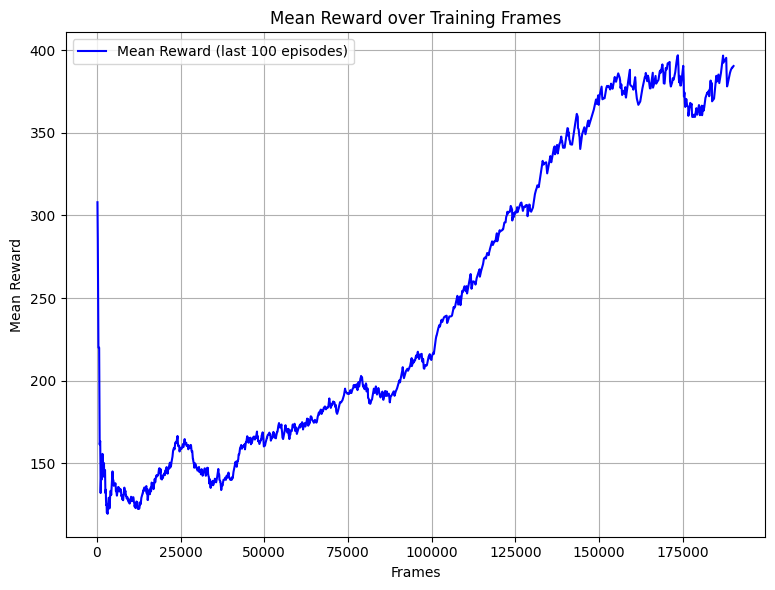

Learning curves for mean reward and loss plotted successfully.


In [ ]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

def get_latest_event_file(log_dir):
    list_of_files = glob(os.path.join(log_dir, '**', 'events.out.tfevents.*'), recursive=True)
    if not list_of_files:
        return None
    latest_file = max(list_of_files, key=os.path.getmtime)
    return latest_file

latest_event_file = get_latest_event_file(log_dir)

if latest_event_file:
    event_acc = EventAccumulator(latest_event_file)
    event_acc.Reload()

    # Extract scalar data
    rewards = []
    losses = []
    frames = []
    loss_frames = []

    if 'reward_100' in event_acc.Tags()['scalars']:
        for s in event_acc.Scalars('reward_100'):
            rewards.append(s.value)
            frames.append(s.step)
    else:
        print("Warning: 'reward_100' not found in scalars. Available tags:", event_acc.Tags()['scalars'])

    if 'loss_t' in event_acc.Tags()['scalars']:
        for s in event_acc.Scalars('loss_t'):
            losses.append(s.value)
            loss_frames.append(s.step)
    else:
        print("Warning: 'loss_t' not found in scalars. Available tags:", event_acc.Tags()['scalars'])

    # Create DataFrames for easier plotting
    df_rewards = pd.DataFrame({'frame_idx': frames, 'mean_reward': rewards})

    # Plotting
    plt.figure(figsize=(15, 6))

    if not df_rewards.empty:
        plt.subplot(1, 2, 1)
        plt.plot(df_rewards['frame_idx'], df_rewards['mean_reward'], label='Mean Reward (last 100 episodes)', color='blue')
        plt.xlabel('Frames')
        plt.ylabel('Mean Reward')
        plt.title('Mean Reward over Training Frames')
        plt.grid(True)
        plt.legend()
    else:
        print("No reward data to plot.")

    if losses:
        df_losses = pd.DataFrame({'frame_idx': loss_frames, 'loss': losses})
        plt.subplot(1, 2, 2)
        plt.plot(df_losses['frame_idx'], df_losses['loss'], label='Loss', color='red')
        plt.xlabel('Frames')
        plt.ylabel('Loss')
        plt.title('Loss over Training Frames')
        plt.grid(True)
        plt.legend()
    else:
        print("No loss data to plot.")

    plt.tight_layout()
    plt.show()

    print("Learning curves for mean reward and loss plotted successfully.")
else:
    print("No TensorBoard event files found in the 'runs' directory.")
